In [1]:
# Process east river 2020/10 stage data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.interpolate import interp1d

In [ ]:
# read gage elevations
gage_loc = pd.read_excel(r"D:\East_river_flood_resilience\Greenbay\HEC-RAS\Unsteady_flow\Gage_location_elevations.xlsx")

In [174]:
gage_loc

,Gage,Elevation (NAVD88),Time,Date,North ft,East ft
0,WZ/PARTRIDGE,627.803,09:56:16,2020-10-21,507222.167,76188.217
1,WZ/MIDWAY,610.771,11:21:53,2020-10-21,520568.886,82757.016
2,WZ/CTH PP,596.230,11:37:01,2020-10-21,527522.218,89676.765
3,WZ/CTH G,581.797,12:22:35,2020-10-21,538486.919,97167.068
4,WZ/BOWER CREEK CTH GV,581.891,12:38:26,2020-10-21,544369.482,104812.720
5,WZ/WILLOW CREEK CTH O,582.520,07:58:35,2020-10-22,552004.077,102868.920
6,WZ/BAIRD CREEK MAIN ST,582.565,08:22:08,2020-10-22,563707.127,107363.964
7,WZ/N BAIRD STREET,582.651,09:38:37,2020-10-22,565573.880,105472.558
8,WZ/MONROE ST BRIDGE,582.667,10:00:53,2020-10-22,568414.438,102079.682


In [160]:
# from patriadge to hwy57
# save gage elevation
gage_datum = pd.DataFrame()
gage_datum['Station'] = gage_loc['Gage']
datum_list = []

gage_name = ['Partridge_Rd','Midway_Rd','Hwy_PP','Hwy_G',"Bower_Creek","Willow_Creek",
            "Baird_Creek","N_Baird_St","HWy_57"]
for j in range(len(gage_name)):
    # gauge data location
    father_loc = r'D:\East_river_flood_resilience\Greenbay\HEC-RAS\Unsteady_flow\Unsteady_flow_data\East_river_gauge_03102021'
    # gauge data location
    gage_location = father_loc + "\\" + gage_name[j] + ".csv"
    # read gage data, skip the first column
    gage_data = pd.read_csv(gage_location, index_col=0, skiprows = 1)
    gage_data.columns = ['Date Time','Depth(feet)']
    gage_data = gage_data.reset_index() # reindex，start from zero
    minute_stamp = np.zeros((gage_data.shape[0], 1))
    index = []
    for i in range(gage_data.shape[0]): # %I is 0-12 hours
        d = datetime.strptime(gage_data['Date Time'][i], '%m/%d/%y %I:%M:%S %p') # convert string to datetime object
        # print(d)
        january1st = datetime(2020, 10, 1) # reference timestamp
        timesince = d - january1st 
        minutessince = int(timesince.total_seconds() / 60) # calculate the minute starting from the reference timestamp
        index.append(d)
        minute_stamp[i] = minutessince
    gage_data['Minute_since'] = minute_stamp
    gage_time = gage_loc['Time'][j].strftime("%H:%M:%S")
    gage_date = gage_loc['Date'][j].strftime("%Y-%m-%d")
    gage_timestamp = gage_date + " " + gage_time
    gage_d = datetime.strptime(gage_timestamp, "%Y-%m-%d %H:%M:%S")
    timesince = gage_d - january1st
    minutessince = timesince.total_seconds() / 60 # get minutes since 2020 10 1
    # Interpolation
    x_new = minutessince
    y_real = gage_loc['Elevation (NAVD88)'][j] # true elevation
    x = gage_data["Minute_since"]
    y = gage_data["Depth(feet)"]
    f = interp1d(x,y) # linear interpolation
    y_new = f(x_new) # interpolated gage depth
    datum = y_real - y_new # real elevation - gage depth to get datum
    print("Station {0} Datum: {1} ft".format(gage_loc['Gage'][j], datum))
    datum_list.append(datum)
    # print(np.diff(minute_stamp, axis = 0).max()) # show the interval of the time seires data
    # print(np.diff(minute_stamp, axis = 0).min()) # show the interval of the time seires data
    # save
    adjusted_gage_data = pd.DataFrame()
    # transform timestep
    new_index = []
    for i in range(gage_data.shape[0]):
        new_date = index[i].strftime("%Y-%m-%d %H:%M:%S")
        new_index.append(new_date)
    adjusted_gage_data['Date_Time'] = new_index
    adjusted_gage_data['Stage(ft)'] = gage_data["Depth(feet)"] + datum # gage depth + elevation
    # save adjusted gage data
    save_folder = r"D:\East_river_flood_resilience\Greenbay\HEC-RAS\Unsteady_flow\Unsteady_flow_data\East_river_gage_oct_2020_0514"
    save_loc = save_folder + "\\" + gage_name[j] + "_adjusted.csv"
    adjusted_gage_data.to_csv(save_loc, index = False)
    print(gage_name[j] + "has been processed.")
    
gage_datum['Datum(NAVD88ft)'] = datum_list # save gage datum
gage_datum.to_csv(r"D:\East_river_flood_resilience\Greenbay\HEC-RAS\Unsteady_flow\Unsteady_flow_data\East_river_gage_oct_2020_0514\gage_datum.csv")

Station WZ/PARTRIDGE Datum: 625.47648 ft
Partridge_Rdhas been processed.
Station WZ/MIDWAY Datum: 609.4704933333333 ft
Midway_Rdhas been processed.
Station WZ/CTH PP Datum: 593.0334033333334 ft
Hwy_PPhas been processed.
Station WZ/CTH G Datum: 579.2434333333333 ft
Hwy_Ghas been processed.
Station WZ/BOWER CREEK CTH GV Datum: 580.53928 ft
Bower_Creekhas been processed.
Station WZ/WILLOW CREEK CTH O Datum: 578.5495333333333 ft
Willow_Creekhas been processed.
Station WZ/BAIRD CREEK MAIN ST Datum: 578.22616 ft
Baird_Creekhas been processed.
Station WZ/N BAIRD STREET Datum: 577.58215 ft
N_Baird_Sthas been processed.
Station WZ/MONROE ST BRIDGE Datum: 578.5866500000001 ft
HWy_57has been processed.


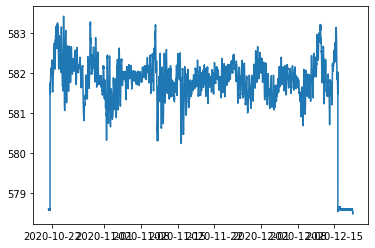

In [161]:
# Visualize gage data
gage_name = ['Partridge_Rd','Midway_Rd','Hwy_PP','Hwy_G',"Bower_Creek","Willow_Creek",
            "Baird_Creek","N_Baird_St","HWy_57"]
save_folder = r"D:\East_river_flood_resilience\Greenbay\HEC-RAS\Unsteady_flow\Unsteady_flow_data\East_river_gage_oct_2020_0514"
save_loc = save_folder + "\\" + "HWy_57" + "_adjusted.csv"
gage_data = pd.read_csv(save_loc)
# create timestamp index
time_index = []
for i in range(gage_data.shape[0]):
    d = datetime.strptime(gage_data['Date_Time'][i], "%Y-%m-%d %H:%M:%S")
    time_index.append(d)
plt.plot(time_index, gage_data["Stage(ft)"])

In [163]:
# Compare the data with oil tank
oil_tank_stage_loc = r'D:\East_river_flood_resilience\Greenbay\HEC-RAS\Unsteady_flow\Unsteady_flow_data\oil_tank_stage_oct20_dec30_processed.csv'
oil_tank_stage = pd.read_csv(oil_tank_stage_loc)
oil_index = []
for i in range(oil_tank_stage.shape[0]):
    d = datetime.strptime(oil_tank_stage['Time'][i], '%m/%d/%Y %H:%M') # convert string to datetime object
    oil_index.append(d)

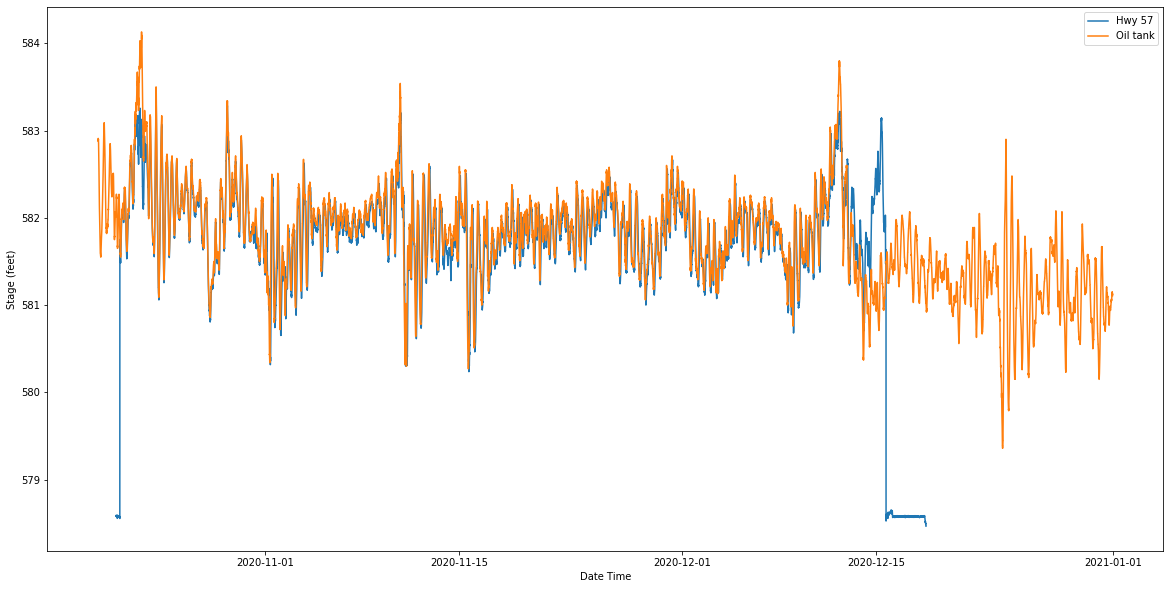

In [173]:
plt.figure(figsize = (20, 10))
plt.plot(time_index, gage_data["Stage(ft)"], label = "Hwy 57")
plt.plot(oil_index, oil_tank_stage["Stage(feet)"], label = "Oil tank")
plt.xlabel('Date Time')
plt.ylabel("Stage (feet)")
plt.legend()

In [3]:
# plot histogram
def drawHist(heights):
    plt.hist(heights, 100)
    plt.xlabel('Heights')
    plt.ylabel('Frequency')
    plt.title('River stage')
    plt.show()
# drawHist(stage)
# drawHist(np.log(stage))


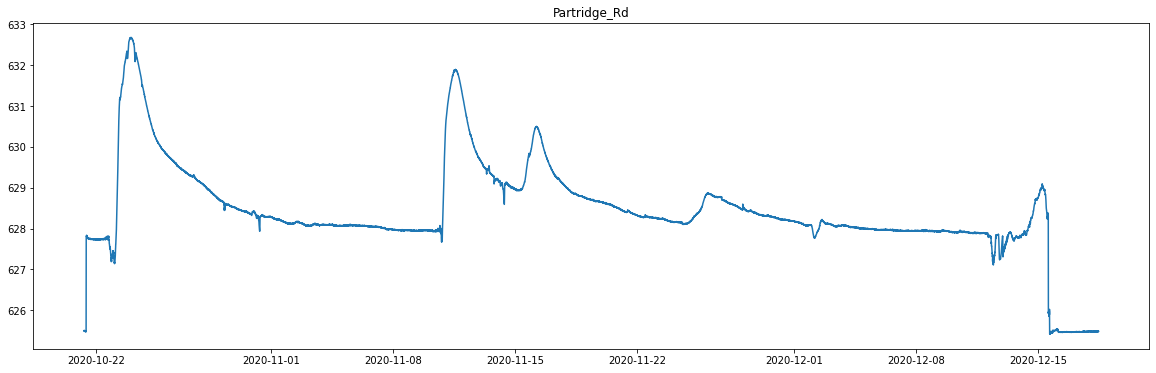

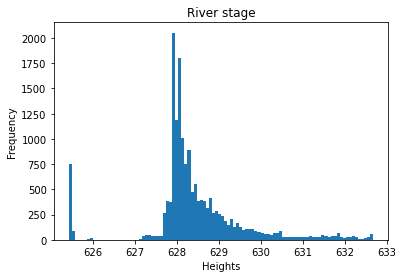

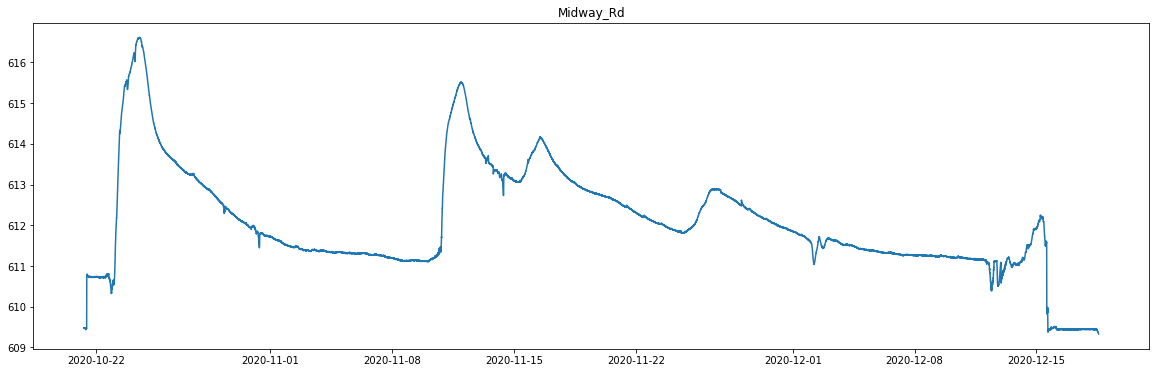

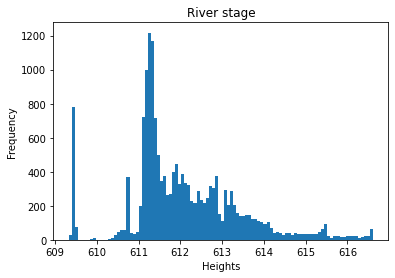

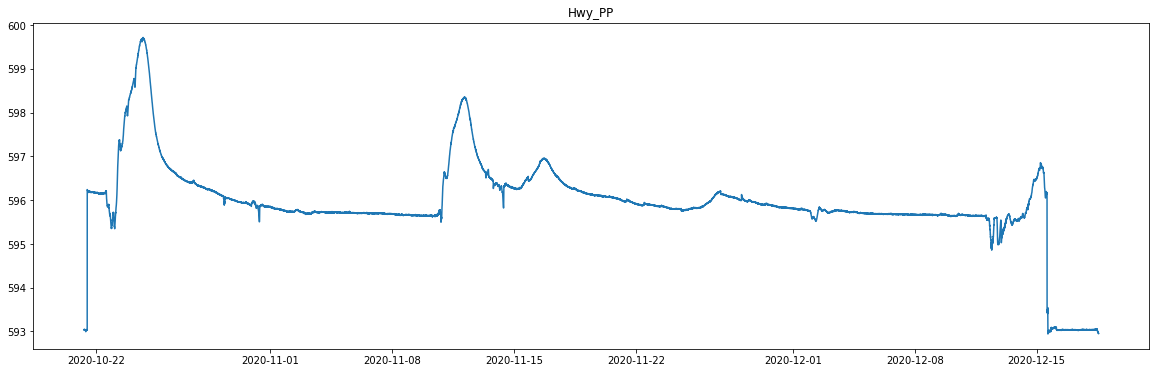

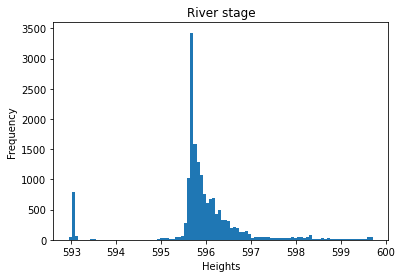

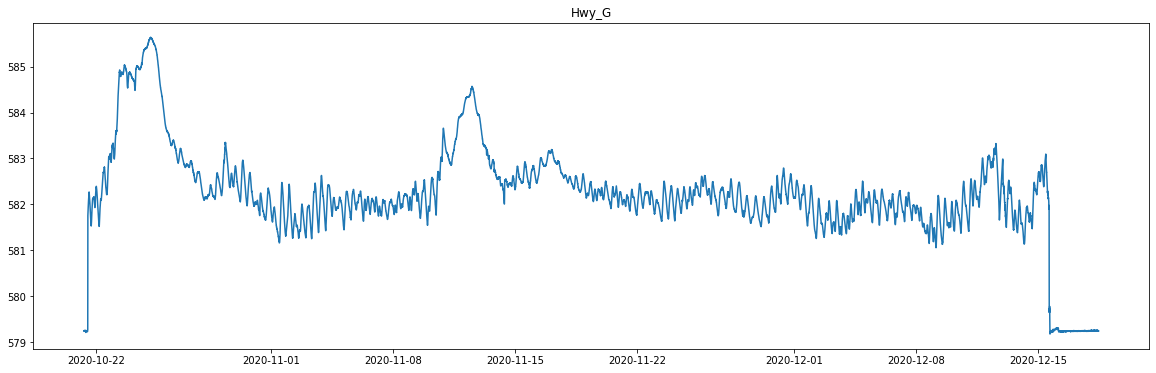

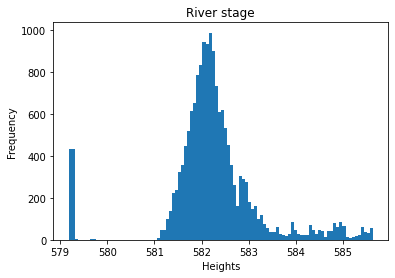

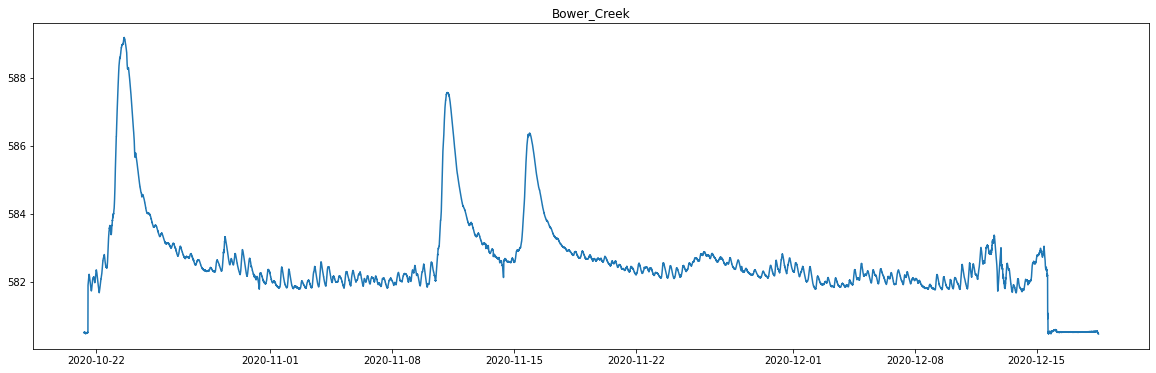

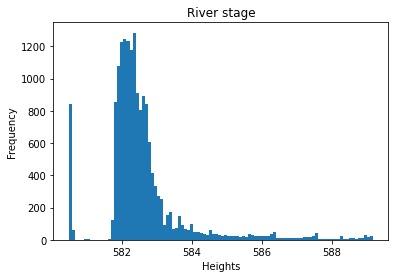

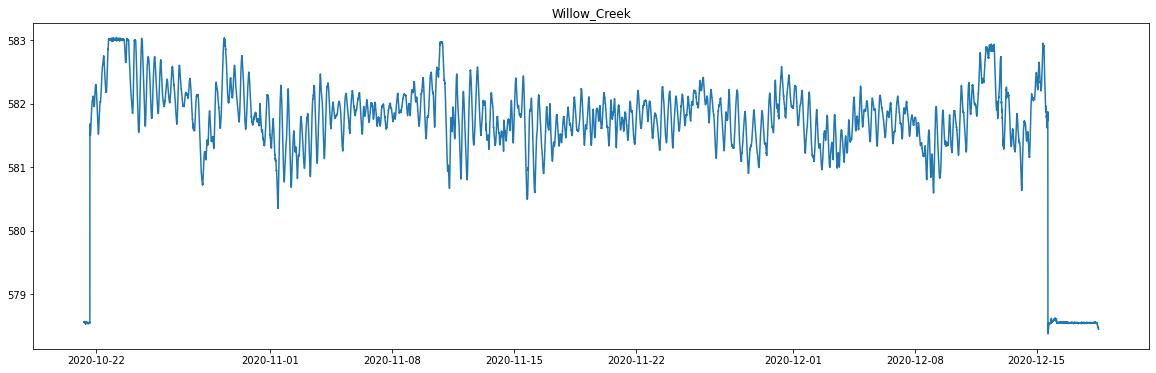

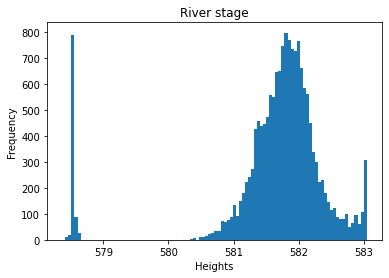

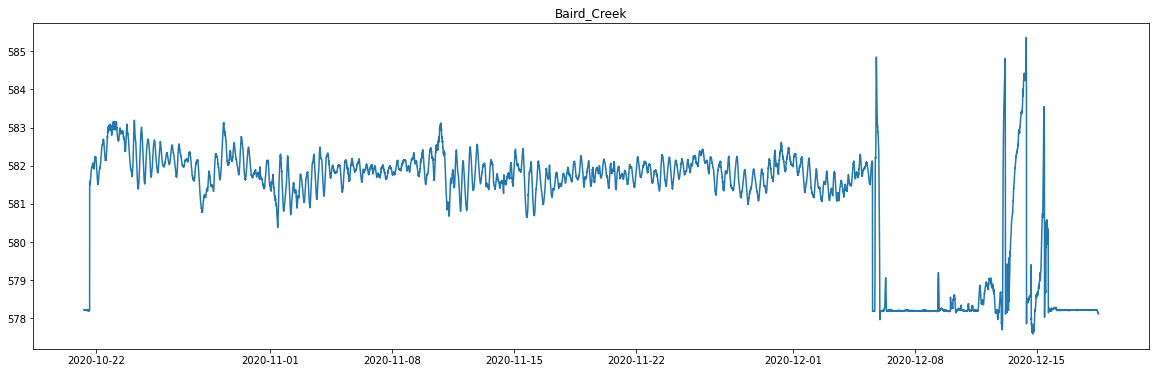

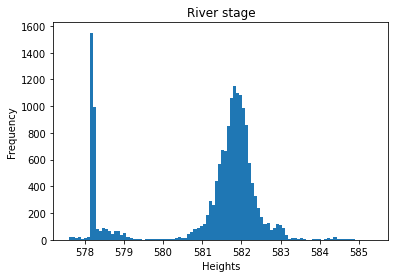

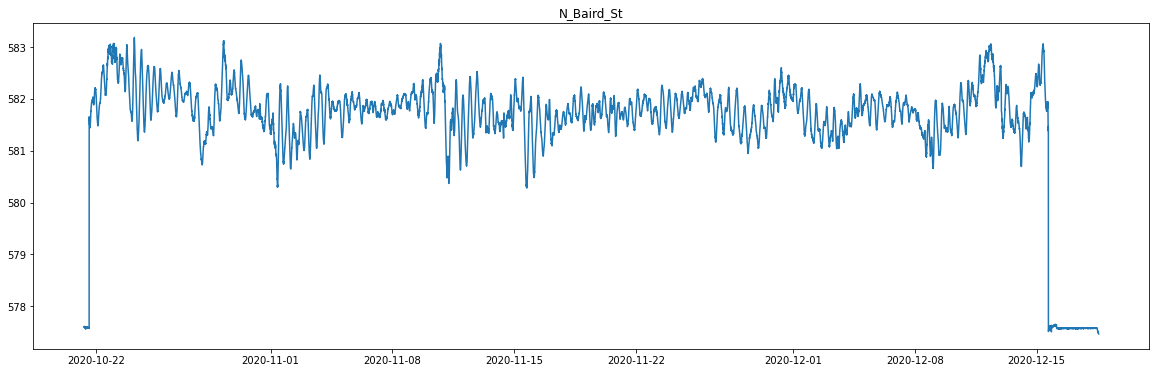

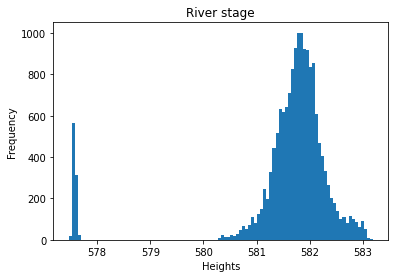

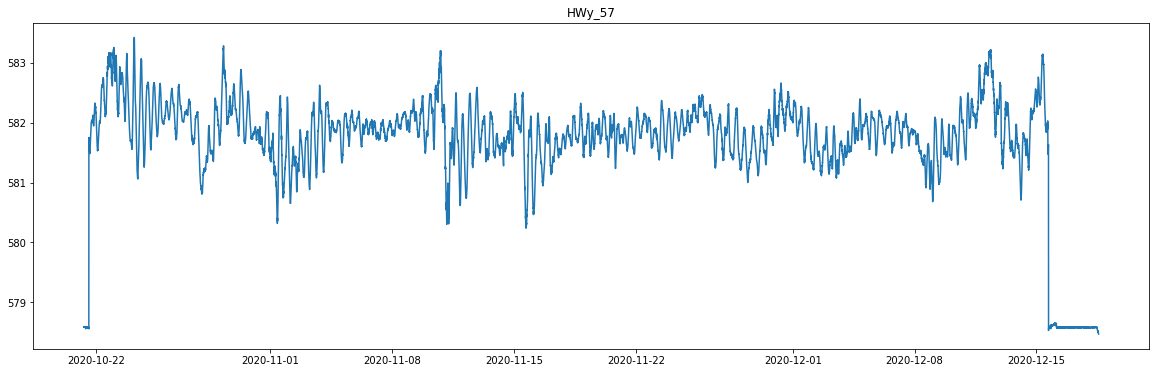

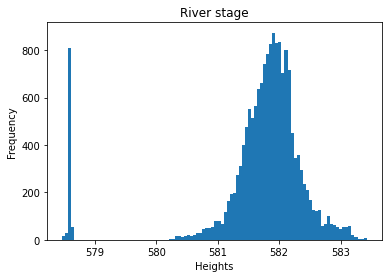

In [7]:
# Visualize gage data
gage_name = ['Partridge_Rd','Midway_Rd','Hwy_PP','Hwy_G',"Bower_Creek","Willow_Creek",
            "Baird_Creek","N_Baird_St","HWy_57"]
save_folder = r"D:\East_river_flood_resilience\Greenbay\HEC-RAS\Unsteady_flow\Unsteady_flow_data\East_river_gage_oct_2020_0514"
for j in range(len(gage_name)):
    ax = plt.figure(figsize = (20, 6))
    save_loc = save_folder + "\\" + gage_name[j] + "_adjusted.csv"
    gage_data = pd.read_csv(save_loc)
    # create timestamp index
    time_index = []
    for i in range(gage_data.shape[0]):
        d = datetime.strptime(gage_data['Date_Time'][i], "%Y-%m-%d %H:%M:%S")
        time_index.append(d)
    plt.plot(time_index, gage_data["Stage(ft)"])
    plt.title(gage_name[j])
    ax1 = plt.figure()
    drawHist(gage_data["Stage(ft)"])

In [ ]:
################################################################# 
# single calculation
# 从patriadge到hwy57
# 存放gage elevation
gage_datum = pd.DataFrame()
gage_datum['Station'] = gage_loc['Gage']
datum_list = []

# gauge data location
father_loc = r'D:\East_river_flood_resilience\Greenbay\HEC-RAS\Unsteady_flow\Unsteady_flow_data\East_river_gauge_03102021'
# gauge data name
gage_name = "Partridge_Rd.csv"
# gauge data location
gage_location = father_loc + "\\" + gage_name
# read gage data, skip the first column
gage_data = pd.read_csv(gage_location, index_col=0, skiprows = 1)
gage_data.columns = ['Date Time','Depth(feet)']
gage_data = gage_data.reset_index() # 重新排序index，从0开始计数
minute_stamp = np.zeros((gage_data.shape[0], 1))
index = []
for i in range(gage_data.shape[0]): # %I 是 0-12 hours
    d = datetime.strptime(gage_data['Date Time'][i], '%m/%d/%y %I:%M:%S %p') # convert string to datetime object
    # print(d)
    january1st = datetime(2020, 10, 1) # reference timestamp
    timesince = d - january1st 
    minutessince = int(timesince.total_seconds() / 60) # calculate the minute starting from the reference timestamp
    index.append(d)
    minute_stamp[i] = minutessince
gage_data['Minute_since'] = minute_stamp
gage_time = gage_loc['Time'][0].strftime("%H:%M:%S")
gage_date = gage_loc['Date'][0].strftime("%Y-%m-%d")
gage_timestamp = gage_date + " " + gage_time
gage_d = datetime.strptime(gage_timestamp, "%Y-%m-%d %H:%M:%S")
timesince = gage_d - january1st
minutessince = timesince.total_seconds() / 60 # 获取距离10月1日的分钟数
# Interpolation
x_new = minutessince
y_real = gage_loc['Elevation (NAVD88)'][0] # 真实高度
x = gage_data["Minute_since"]
y = gage_data["Depth(feet)"]
f = interp1d(x,y) # linear interpolation
y_new = f(x_new) # 差值后得到的gage depth
datum = y_real - y_new # 真实高度 - gage depth得到 datum
print("Station {0} Datum: {1} ft".format(gage_loc['Gage'][0], datum))
datum_list.append(datum)
# print(np.diff(minute_stamp, axis = 0).max()) # show the interval of the time seires data
# print(np.diff(minute_stamp, axis = 0).min()) # show the interval of the time seires data
################################################################# 